Datos: https://www.kaggle.com/crowdflower/twitter-airline-sentiment/data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import sklearn.preprocessing
sns.set(style='whitegrid', color_codes=True)

In [2]:
data = pd.read_csv('Tweets.csv', encoding='utf-8')

In [3]:
# Agregamos información sobre el encoding del texto
import chardet
data['text_encoding'] = data['text'].apply(lambda t: chardet.detect(bytes(t, encoding='utf-8'))['encoding'])

In [4]:
# Transformamos los sentimientos en numeros
airline_sentiment_encoder = sk.preprocessing.LabelEncoder()
airline_sentiment_encoder.fit(data['airline_sentiment'])
data['airline_sentiment_code'] = airline_sentiment_encoder.transform(data['airline_sentiment'])

# Análisis de Datos

## airline_sentiment

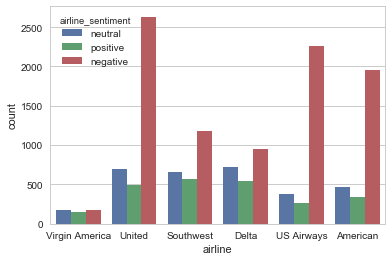

In [3]:
sns.countplot(x='airline', hue='airline_sentiment', data=data);

Mirando este plot se ven dos cosas muy claramente que tenemos un amplio desbalance de clases (muchísimos samples negativos contra positivos y neutrales). Esto quiere decir que vamos a tener que tomar precauciones en nuestras métricas para asegurarnos la buena performance del modelo.

Especificamente, los porcentajes son:

In [100]:
data['airline_sentiment'].value_counts()/len(data)*100.0

negative    62.691257
neutral     21.168033
positive    16.140710
Name: airline_sentiment, dtype: float64

## airline_sentiment_confidence

Debido a que existe esta feature, sabemos que muy probablemente haya valores para los cuales no estemos seguros de cuál es el verdadero sentimiento que quiere transmitir el tweet. Veamos cómo se vé la situación:

/home/jbayardo/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


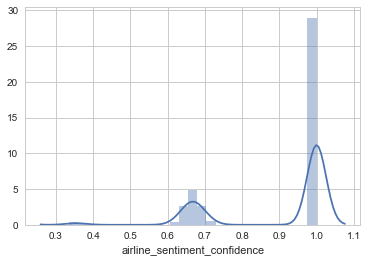

In [4]:
sns.distplot(data['airline_sentiment_confidence'])

In [5]:
data['airline_sentiment_confidence'].describe()

count    14640.000000
mean         0.900169
std          0.162830
min          0.335000
25%          0.692300
50%          1.000000
75%          1.000000
max          1.000000
Name: airline_sentiment_confidence, dtype: float64

Dado que menos del 25% de los datos tiene una confianza menor a el ~70%, vamos a tomar el corte en 0.68.

## airline_sentiment_gold

In [101]:
data['airline_sentiment_gold'].dropna()

1286     negative
2017     negative
2135      neutral
2201     negative
2383     negative
3005     negative
3149     negative
4206     negative
4525     positive
5183     negative
5341     negative
5749      neutral
5810     negative
6530     negative
6632     negative
6728      neutral
6758     negative
8096     negative
8207     negative
8536     negative
8739     negative
9493     negative
9536     negative
11053    positive
12024    positive
12025    negative
12026    negative
12027    negative
12028    negative
12029    negative
12030    negative
12031    negative
12032    negative
12033    positive
12034    negative
12035    negative
12036    positive
12037    negative
12038    negative
12039    negative
Name: airline_sentiment_gold, dtype: object

# Limpiando el texto

Twitter es una fuente de texto muy ruidosa: la gente escribe con abreviaciones, errores de ortografía, etcétera. vamos a utilizar algunos métodos para uniformizar el texto.

In [5]:
import re
import nltk
import gensim
from bs4 import BeautifulSoup

In [102]:
# El texto que proviene de Twitter viene con caracteres de html como &amp;.
def parse_html(tweet):
    return BeautifulSoup(tweet, 'html.parser').get_text()
    

# También viene con caracteres de UTF-8 que representan emojis o dibujos de algún tipo.
# Esto es un intento de eliminarlos dentro de lo posible.
emoji_regex = re.compile(
    u"(\ud83d[\ude00-\ude4f])|"  # emoticons
    u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
    u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
    u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
    u"(\ud83c[\udde0-\uddff])"  # flags (iOS)
    "+", flags=re.UNICODE)
def remove_emojis(tweet):
    return emoji_regex.sub(r'', tweet)

# Con esta función borramos todos los @mentions.
handle_regex = re.compile(r"(?<![A-Za-z0-9_!@#\$%&*])@(([A-Za-z0-9_]){20}(?!@))|(?<![A-Za-z0-9_!@#\$%&*])@(([A-Za-z0-9_]){1,19})(?![A-Za-z0-9_]*@)")
def remove_handles(tweet):
    return handle_regex.sub(' ', tweet)

# Acá hacemos que más de 1 white space se convierta en uno sólo
whitespace_regex = re.compile(r'\s{2,}')
def remove_multiple_whitespace(tweet):
    return whitespace_regex.sub(' ', tweet).strip()

# Y acá transformamos las lineas nuevas en puntos, para que el tokenizer ande mejor.
newline_regex = re.compile(r'(\r\n|\r)+')
def replace_newlines(tweet):
    return newline_regex.sub('. ', tweet).strip()

# Eliminamos URLs
url_regex = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
def remove_urls(tweet):
    return url_regex.sub('', tweet)

# Y le sacamos el # a los #hashtags
hashtag_regex = re.compile(r'\#([A-Za-z0-9]+)')
def clean_hashtags(tweet):
    return hashtag_regex.sub(r'\1', tweet).strip()

# Replace repeated character sequences of length 3 or greater with sequences of length 3.
# http://www.nltk.org/_modules/nltk/tokenize/casual.html#TweetTokenizer
lengthening_regex = re.compile(r"(.)\1{2,}")
def reduce_lengthening(text):
    return lengthening_regex.sub(r"\1\1\1", text)

# Expandimos todas las contracciones que podemos del ingles, para que cuenten como palabras distintas.
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd've": "he would have",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "I'd've": "I would have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd've": "it would have",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd've": "she would have",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "that'd've": "that would have",
    "there'd've": "there would have",
    "they'd've": "they would have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what're": "what are",
    "what've": "what have",
    "when've": "when have",
    "where'd": "where did",
    "where've": "where have",
    "who've": "who have",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd've": "you would have",
    "you're": "you are",
    "you've": "you have"
}
for contraction in list(contractions.keys()):
    repl = contraction.replace("'", "’")
    if repl != contraction:
        contractions[repl] = contractions[contraction]

for contraction in list(contractions.keys()):
    lowered = contraction.lower()
    if lowered != contraction:
        contractions[lowered] = contractions[contraction].lower()
contractions_regex = re.compile(r'\b(' + '|'.join(contractions.keys()) + r')\b', re.IGNORECASE)
def replace_contractions(tweet):
    return contractions_regex.sub(lambda x: contractions[x.group().lower()], tweet)


pipeline = [parse_html,
            remove_emojis,
            replace_contractions,
            remove_handles,
            clean_hashtags,
            remove_urls,
            remove_multiple_whitespace,
            replace_newlines]

#pipeline = [lambda x: x]
clean = []
for t in data['text'].values:
    current = t
    for f in pipeline:
        current = f(current)
    clean.append(current)
data['text_clean'] = pd.Series(clean)
del clean

In [74]:
list(data['text_clean'])

['What said.',
 'plus you have added commercials to the experience... tacky.',
 'I did not today... Must mean I need to take another trip!',
 'it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces & they have little recourse',
 "and it's a really big bad thing about it",
 "seriously would pay $30 a flight for seats that did not have this playing.\nit's really the only bad thing about flying VA",
 'yes, nearly every time I fly VX this “ear worm” will not go away :)',
 'Really missed a prime opportunity for Men Without Hats parody, there.',
 'Well, I did not…but NOW I DO! :-D',
 'it was amazing, and arrived an hour early. you are too good to me.',
 'did you know that suicide is the second leading cause of death among teens 10-24',
 'I <3 pretty graphics. so much better than minimal iconography. :D',
 'This is such a great deal! Already thinking about my 2nd trip to & I have not even gone on my 1st trip yet! ;p',
 'i am flying your fabulous Seductive skies agai

# Ideas

## Bag of Words

In [110]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [76]:
nltk_data = data.query('text_encoding == "ascii" and airline_sentiment_confidence > 0.65')

In [77]:
train, test = train_test_split(nltk_data, test_size=0.2, random_state=1)
X_train = train['text_clean'].values
y_train = train['airline_sentiment_code']

X_test = test['text_clean'].values
y_test = test['airline_sentiment_code']

In [78]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 2),
    stop_words = en_stopwords)

In [112]:
from sklearn.svm import SVC
np.random.seed(1)

clf = SVC(probability=True, kernel="linear", class_weight="balanced")

pipeline_svm = make_pipeline(
    vectorizer,
    MaxAbsScaler(),
    clf)

kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="f1_weighted",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  5.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'svc__C': [0.01, 0.1, 1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1_weighted',
       verbose=1)

In [113]:
from sklearn.metrics import confusion_matrix
y_test_predicted = grid_svm.best_estimator_.predict(X_test)
confusion_matrix(y_test, y_test_predicted)/len(y_test)*100.0

array([[54.32673652,  9.00271634,  3.14318976],
       [ 4.65657742, 11.75785797,  1.55219247],
       [ 2.09545984,  2.05665503, 11.40861467]])

In [114]:
from sklearn.metrics import confusion_matrix
y_train_predicted = grid_svm.best_estimator_.predict(X_train)
confusion_matrix(y_train, y_train_predicted)/len(y_train)*100.0

array([[6.20341615e+01, 3.07647516e+00, 4.65838509e-01],
       [2.42624224e-01, 1.89635093e+01, 3.78493789e-01],
       [1.94099379e-02, 1.94099379e-01, 1.46253882e+01]])

## String Kernel

In [11]:
import shogun

In [45]:
# Shogun sólo soporta ASCII, así que sólo nos quedamos con los puntos que tienen texto soportado.
shogun_data = data.query('text_encoding == "ascii"')[['text', 'clean_text', 'airline_sentiment_code']].head(1000)
shogun_X = list(shogun_data['clean_text'].values)
shogun_y = shogun_data['airline_sentiment_code'].values.astype(np.float64)

In [46]:
shogun_train_features = shogun.StringCharFeatures(shogun_X, shogun.RAWBYTE)
shogun_train_labels = shogun.MulticlassLabels(shogun_y)

shogun_string_kernel = shogun.SubsequenceStringKernel(shogun_train_features, shogun_train_features, 3, 0.5)

# Train the Support Vector Machine
C = 1.0
shogun_clf = shogun.MulticlassLibSVM(C, shogun_string_kernel, shogun_train_labels)
shogun_clf.train()

/home/jbayardo/anaconda3/envs/shogun/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: [WARN] In file /home/conda/feedstock_root/build_artifacts/shogun-cpp_1526243095433/work/src/shogun/multiclass/MulticlassOneVsOneStrategy.cpp line 34: MulticlassOneVsOneStrategy::CMulticlassOneVsOneStrategy(): register parameters!



True

In [47]:
predicted_labels = shogun_clf.apply_multiclass(shogun_train_features)

In [48]:
evaluator = shogun.MulticlassAccuracy()
accuracy = evaluator.evaluate(predicted_labels, shogun_train_labels)

## Word Vectors